In [1]:
import glob
import os
from astropy.io import fits
import matplotlib.pyplot as plt
import numpy as np
from astropy.io import ascii
from astropy.table import Table

plt.rcParams['figure.facecolor']    = 'white'
import pandas as pd    
from datetime import date
today=date.today()
DATE =today.strftime("%m_%d_%y")
print(DATE)
import glob
from astropy.coordinates import SkyCoord, EarthLocation
import astropy.units as u

vlt = EarthLocation.of_site('paranal')  # the easiest way... but requires internet


# from utils import *

07_31_25


In [2]:
files_113 = glob.glob('../data/p113_data/*.fits')
files_112 = glob.glob('../data/p112_data/*.fits')
li_line = 6707.926


In [40]:
with fits.open(files_113[0]) as hdul:
    hdul = fits.open(files_113[0])
    header  = hdul[0].header
header
    

SIMPLE  =                    T / file does conform to FITS standard             
BITPIX  =                   16 / number of bits per data pixel                  
NAXIS   =                    0 / number of data axes                            
EXTEND  =                    T / FITS dataset may contain extensions            
COMMENT   FITS (Flexible Image Transport System) format is defined in 'Astronomy
COMMENT   and Astrophysics', volume 376, page 359; bibcode: 2001A&A...376..359H 
DATE    = '2024-08-05T08:25:50' / file creation date (YYYY-MM-DDThh:mm:ss UT)   
ORIGIN  = 'ESO-PARANAL'        / European Southern Observatory                  
OBJECT  = 'TYC 8728-2561-1'    / Original target.                               
RA      =           263.138659 / [deg] Spectroscopic target position (J2000)    
DEC     =            -53.58522 / [deg] Spectroscopic target position (J2000)    
EXPTIME =                 300. / [s] Total integration time per pixel           
MJD-OBS =       60497.138813

In [3]:
def get_files(files):
    obj_dir = {}
    c=3e5 #km/s

    for i,file in enumerate(files):
        with fits.open(file) as hdul:
            hdul = fits.open(file)
            header  = hdul[0].header
            #print(header.cards['HIERARCH ESO QC CCF RV ERROR'])
            data    = hdul[1].data
            time    = header['HIERARCH ESO QC BJD']
            name    = header['OBJECT']
            obj     = int(header['HIERARCH ESO OBS NAME'].split('-')[0][2:])
            grade   = header['OB_GRADE'].replace(" ", "")
            if grade =='C':
                print('RG',obj,header['OB_GRADE'])
                continue

            ra,dec  = header['RA'], header['DEC']
            obs_T   = header['DATE-OBS'].split('T')[0]
            rv_val  =  header['HIERARCH ESO QC CCF RV']#header['HIERARCH ESO OCS OBJ RV'] #km/s
            rv_err  = header['HIERARCH ESO QC CCF RV ERROR'] #km/s
            sc = SkyCoord(ra=ra*u.deg, dec=dec*u.deg)
            rv_corr = rv_val
            err_corr = rv_err
            if name=='UCAC4 308-077592':
                if obj in obj_dir.keys():
                    obj_dir[obj]['file'].append(file)
                    obj_dir[obj]['rv'].append(rv_corr)
                    obj_dir[obj]['time'].append(time)
                    obj_dir[obj]['err'].append(err_corr)
                    obj_dir[obj]['name'].append(name)
                    obj_dir[obj]['grade'].append(grade)
                else:
                    obj_dir[obj] = {'file': [file], 'rv': [rv_corr], 
                                    'time': [time], 'err': [err_corr], 
                                    'name': [name], 'grade': [grade]}
            else:
                if rv_corr >= -100:
                    if obj in obj_dir.keys():
                        obj_dir[obj]['file'].append(file)
                        obj_dir[obj]['rv'].append(rv_corr)
                        obj_dir[obj]['time'].append(time)
                        obj_dir[obj]['err'].append(err_corr)
                        obj_dir[obj]['name'].append(name)
                        obj_dir[obj]['grade'].append(grade)
                    else:
                        obj_dir[obj] = {'file': [file], 'rv': [rv_corr], 
                                        'time': [time], 'err': [err_corr], 
                                        'name': [name], 'grade': [grade]}
    print(len(obj_dir.keys()))   
    targets_to_remove = []
    for k, v in obj_dir.items():
        if len(v['time']) < 3:
            targets_to_remove.append(k)
    for i in range(len(targets_to_remove)):
        del obj_dir[targets_to_remove[i]]
    print(len(obj_dir.keys()))

    myKeys = list(obj_dir.keys())
    myKeys.sort()
    obj_dir = {i: obj_dir[i] for i in myKeys}
    return obj_dir
obj_dir_112 = get_files(files_112)
obj_dir_113 = get_files(files_113)

RG 20 C
RG 13 C
RG 14 C
RG 1 C
19
10
RG 12 C
RG 6 C
RG 3 C
RG 11 C
RG 22 C
RG 15 C
RG 3 C
RG 8 C
RG 3 C
RG 25 C
RG 8 C
RG 22 C
RG 3 C
RG 7 C
RG 23 C
25
25


In [4]:
def rv_correct(rg, obj_dir, lower_wave, plot=False):
    c = 3e5 #km/s
    files = obj_dir[rg]['file']
    rvs    = obj_dir[rg]['rv']
    plt.figure(figsize=(15,10))

    all_flux = []
    all_wave = []
    all_ferr = [] #flux_err
    for i,file in enumerate(files):
        with fits.open(file) as hdul:
            hdul = fits.open(file)
            header = hdul[0].header
            data  = hdul[1].data
            rv_val  =  header['HIERARCH ESO QC CCF RV']#header['HIERARCH ESO OCS OBJ RV'] #km/s
            wave, flux = data['WAVE_AIR'][0], data['FLUX    '][0]
            flux_err   = data['ERR'][0]
            mask       = (wave > lower_wave)
            wave, flux = wave[mask], flux[mask]
            flux_err   = flux_err[mask]
            plt.subplot(len(files),1,i+1)
            plt.plot(wave, flux, lw=0.5)
            plt.axvline(li_line,c='C1')
            plt.xlim(6700, 6717)
            mask = (wave >= 6708) & (wave <= 6710)
            new_wave = wave[mask]
            new_flux = flux[mask]
            w0 = li_line*1
            w1 = new_wave[np.argmin(new_flux)]
            shift = (rv_val/c)*(w0)
            #print((w1 - w0)*c/w0, rv_val, shift)
            plt.plot(wave-shift, flux)
            
            corrected_wave = wave-shift
            all_wave.append(corrected_wave)
            all_flux.append(flux)
            all_ferr.append(flux_err)      
    plt.tight_layout()
    if not plot: plt.close()
    return all_wave, all_flux, all_ferr
    
_,_,_ = rv_correct(1, obj_dir_112, lower_wave=4500.)



In [5]:
def interp_wave(w, f, fe):
    '''
    interpolate all the wavelength to same grid for target spectrum
    @input:
        w : original wavelength grid of each observation after RV correction
        f : flux values of each observation
    '''
    
    wave_grid = w[0]

    all_flux = []
    all_flux.append(f[0])
    
    all_ferr = []
    all_ferr.append(fe[0])
    
    for i in range(1,len(w)):
        target_wave, target_flux, target_ferr = w[i],f[i],fe[i]
        target_flux_interp = np.interp(wave_grid, target_wave, target_flux)
        target_ferr_interp = np.interp(wave_grid, target_wave, target_ferr)
        all_flux.append(target_flux_interp)
        all_ferr.append(target_ferr_interp)
       
    return wave_grid, all_flux, all_ferr


In [6]:
def stack(all_flux,plot=False):
    stacked = np.sum(np.array(all_flux), axis=0)
    if plot:# plot stacked spectra
        plt.figure(figsize=(10,4))

        for spectrum in all_flux:
            plt.plot(w,spectrum)

        plt.plot(w,stacked,label='stacked')
        plt.legend()
        plt.xlim(6550,6570)
        plt.ylim(0,0.4e-12)

        plt.tight_layout()
    return stacked


In [7]:
table4 = pd.read_csv('table4.csv')
rv_df = pd.read_csv('comb_rvs.csv')
    

In [8]:
import arviz as az
import corner

In [9]:
import thejoker as tj


In [10]:
def clean_up(df):
    time = df['comb_time']
    rv = df['comb_rv']
    err = df['comb_rv_err']
    
    time = time.values[0].split('[')[-1].split(']')[0].split(' ')#[:-1]
    time = [t for t in time if len(t) > 0]
    time = [float(t.split('\n')[0].replace("'","")) for t in time]
    
    rv = rv.values[0].split('[')[-1].split(']')[0].split(' ')#[:-1]
    rv = [t for t in rv if len(t) > 0]
    rv = [float(t.split('\n')[0]) for t in rv]
    
    err = err.values[0].split('[')[-1].split(']')[0].split(' ')#[:-1]
    err = [t for t in err if len(t) > 0]
    err = [float(t.split('\n')[0]) for t in err]
    
    return time, rv, err
from astropy.time import Time


In [11]:
binary_list_113 = 1, 4, 5, 7, 9, 11, 16, 18, 19, 21, 23  
binary_list_112 = 5, 6, 7, 23 #13 removed because of dipper star

In [25]:
before = pd.read_csv('table4_1.csv')
before[(before.program==112) & (before.RG_id==23)].P50

4    36.052367
Name: P50, dtype: float64

In [37]:
table4[(table4.program==113) & (table4.RG_id==16)]
galah

NameError: name 'galah' is not defined

/opt/miniconda3/lib/python3.9/site-packages/xarray/core/concat.py:527: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  common_dims = tuple(pd.unique([d for v in vars for d in v.dims]))


20.610582360643786 19.67748519568736
0.8648927012490373 0.245722536607039


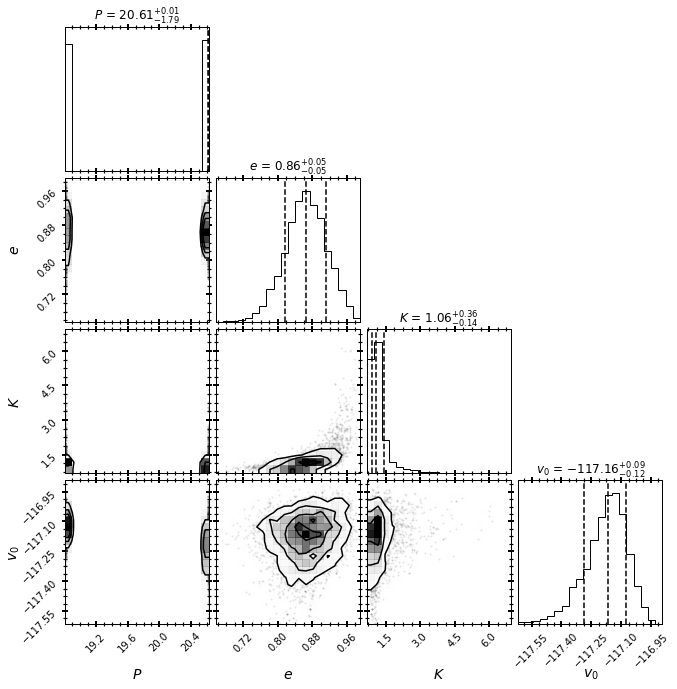

In [33]:
import pickle
# for RG in binary_list_113:
program=113
RG=5
version = 2
fname = '../mcmc/%s_%s_mcmc_%s.pickle'%(program,RG,version)

with open(fname, 'rb') as handle:
    mcmc_samples = pickle.load(handle)
fname2 = '../mcmc/%s_%s_trace_%s.pickle'%(program,RG,version)
with open(fname2, 'rb') as handle:
    trace = pickle.load(handle)
fname3   = '../mcmc/%s_%s_joker_%s.hdf5'%(program,RG,version)

Ps = mcmc_samples['P'].value
es = mcmc_samples['e'].value
Ks = mcmc_samples['K'].value
try:
    print(np.percentile(Ps, 50),table4[(table4.program==program) & (table4.RG_id==RG)]['P50'].values[0])
    print(np.percentile(es, 50),table4[(table4.program==program) & (table4.RG_id==RG)]['e50'].values[0])
except Exception as e:
    print(e)
colnames = ['P','e','K','v0']
summary = az.summary(trace, colnames)
rhat = summary['r_hat'].to_list() 

fig = corner.corner(mcmc_samples.tbl.to_pandas()[colnames], 
                    labels=[
                        r"$P$", r"$e$", r"$K$",r"$v_0$"],
                    quantiles=[0.16, 0.5, 0.84],
                    show_titles=True,
                    title_kwargs={"fontsize": 12}
                   )

dft = table4[(table4.program==program) & (table4.RG_id==RG)]
joker_samples = tj.JokerSamples.read(fname3)
time, rv, rv_err = clean_up(dft)


In [ ]:
plt.figure(figsize=(10,4))
from utils import PLOT_PARAMS
PLOT_PARAMS()
ax=plt.subplot(111)
data = Table()
data['bjd']     = time
data['rv']      = rv
data['rv_err']  = rv_err
data["rv"].unit = u.km / u.s
data["rv_err"].unit = u.km / u.s

data = tj.RVData(
    t=Time(data["bjd"], format="jd", scale="tcb"),
    rv=u.Quantity(data["rv"]),
    rv_err=u.Quantity(data["rv_err"]))

_ = tj.plot_rv_curves(joker_samples, data=data, ax=ax)

In [ ]:
ss

In [ ]:
import pickle 

program = 113
version = 1

for RG in binary_list_113:
    fname = '../mcmc/%s_%s_mcmc_%s.pickle'%(program,RG,version)

    with open(fname, 'rb') as handle:
        mcmc_samples = pickle.load(handle)
    fname2 = '../mcmc/%s_%s_trace_%s.pickle'%(program,RG,version)
    with open(fname2, 'rb') as handle:
        trace = pickle.load(handle)
    fname3   = '../mcmc/%s_%s_joker_%s.hdf5'%(program,RG,version)

    Ps = mcmc_samples['P'].value
    es = mcmc_samples['e'].value
    Ks = mcmc_samples['K'].value
    try:
        print(np.percentile(Ps, 50),table4[(table4.program==program) & (table4.RG_id==RG)]['P50'].values[0])
        print(np.percentile(es, 50),table4[(table4.program==program) & (table4.RG_id==RG)]['e50'].values[0])
    except Exception as e:
        print(e)
    colnames = ['P','e','K','v0']
    summary = az.summary(trace, colnames)
    rhat = summary['r_hat'].to_list() 

    fig = corner.corner(mcmc_samples.tbl.to_pandas()[colnames], 
                        labels=[
                            r"$P$", r"$e$", r"$K$",r"$v_0$"],
                        quantiles=[0.16, 0.5, 0.84],
                        show_titles=True,
                        title_kwargs={"fontsize": 12}
                       )

    # Save the combined plot to a new PNG file
    plt.savefig('final_corner_plots/0_%s_%s.png'%(program, RG), bbox_inches='tight',dpi=200)
    plt.close()
    
    dft = table4[(table4.program==program) & (table4.RG_id==RG)]
    joker_samples = tj.JokerSamples.read(fname3)
    time, rv, rv_err = clean_up(dft)
    plt.figure(figsize=(10,4))
    from utils import PLOT_PARAMS
    PLOT_PARAMS()
    ax=plt.subplot(111)
    data = Table()
    data['bjd']     = time
    data['rv']      = rv
    data['rv_err']  = rv_err
    data["rv"].unit = u.km / u.s
    data["rv_err"].unit = u.km / u.s

    data = tj.RVData(
        t=Time(data["bjd"], format="jd", scale="tcb"),
        rv=u.Quantity(data["rv"]),
        rv_err=u.Quantity(data["rv_err"]))

    _ = tj.plot_rv_curves(joker_samples, data=data, ax=ax)
    plt.savefig('final_corner_plots/1_%s_%s.png'%(program, RG), bbox_inches='tight',dpi=200)
    plt.close()

    from PIL import Image
    # Load the PNG images
    image1 = Image.open('final_corner_plots/0_%s_%s.png'%(program, RG))  # Replace 'image1.png' with your first image file
    image2 = Image.open('final_corner_plots/1_%s_%s.png'%(program, RG))  # Replace 'image2.png' with your second image file
    fig, axes = plt.subplots(1, 2, figsize=(10, 5)) # Adjust figsize as needed

    axes[0].imshow(image1)
    axes[0].axis('off')  # Hide axes ticks and labels

    # Display the second image in the second subplot
    axes[1].imshow(image2)
    axes[1].axis('off')  # Hide axes ticks and labels

    # Adjust layout to prevent overlap
    fig.suptitle('%s - %s'%(program, RG),fontsize=14)
    plt.tight_layout()
    
    plt.savefig('final_corner_plots/%s_%s.png'%(program, RG), bbox_inches='tight',dpi=200)
    plt.close()

In [ ]:
ss

In [ ]:
ss

In [ ]:
np.percentile(Ps, 50)

In [ ]:
table4[(table4.program==112) & (table4.RG_id==23)][['P50','e50']]

In [ ]:
table4[(table4.program==113) & (table4.RG_id==16)][['P50','e50']]

In [ ]:
def load_template(RG, program):
    
    table4 = pd.read_csv('table4.csv')
    rv_df = pd.read_csv('comb_rvs.csv')
    vbroad = rv_df[(rv_df.program==program) & (rv_df.RG_id==RG)].vbroad.values[0]

    templates = glob.glob('../files/Arcturus_templates/arcturus_*.txt')
    fname = '../files/Arcturus_templates/arcturus_vsini_%s.txt'%vbroad
    
    print(vbroad, fname)    
    
    template_og = pd.read_csv(fname,delimiter=' ')
    return template_og


In [ ]:
def interp_template(wave_grid, template,plot=False):
    
    min_wave_esp, max_wave_esp = min(wave_grid), max(wave_grid)
    
    template = template[(template.waveobs <= max_wave_esp) & (template.waveobs >= min_wave_esp)]
    temp_wave = np.array(template.waveobs)
    temp_flux = np.array(template.flux)
    temp_flux_interp = np.interp(wave_grid, temp_wave, temp_flux)

    print('N points in target spectrum:',len(wave_grid))
    print('N points in template spectrum:',len(temp_wave))
    if plot:
        plt.figure(figsize=(10,4),dpi=200)

        plt.plot(temp_wave, temp_flux, label='OG template')
        plt.plot(wave_grid, temp_flux_interp, label='interpolate template')
        plt.xlim(6550,6570)
        plt.ylim(0.5,1.1)
    return temp_flux_interp


In [ ]:
def id_cont(wave, flux, percentage=5):
    '''
    identify continuum
    percentage of spectra to mask out; default is 5%
    '''
    percentage /= 100
    lower, upper = 1-percentage,1+percentage,
    mask = (flux<=upper) & (flux>=lower)
    return mask
    
def fit_cont(wave, flux, order=3):
    '''
    fit the continuum with polynomial
    '''
    coefficients  = np.polyfit(wave, flux, order) # Fit a n-order polynomial
    poly_function = np.poly1d(coefficients)
    fitted_flux   = poly_function(wave)
    return poly_function
    

In [ ]:
plt.rcParams['figure.facecolor'] = 'white'


In [ ]:
rv_df

In [ ]:
def pipeline(RG, obj_dir, program, lower_wave, percentage=5, close=False, savefig=False, savetxt=False):
    
    # load RV corrected spectra
    wave, flux, ferr      = rv_correct(RG, obj_dir, lower_wave)
    
    # interpolate RV corrected spectra onto one grid
    wave_grid, flux, ferr = interp_wave(wave, flux, ferr)
    
    # stack all target spectrum
    stacked_flux     = stack(flux,plot=False)
    avg_ferr         = np.mean(ferr, axis=0)
    
    target_flux      = stacked_flux*1

    # load template based on each target's vbroad
    template         = load_template(RG, program)
    
    # interpolate the template onto target spectrum grid
    temp_flux_interp = interp_template(wave_grid, template)           
    
    # identify the continuum in the template
    cont_mask        = id_cont(wave_grid, temp_flux_interp, percentage) 
    
#     plt.figure(figsize=(10,4),dpi=200)
#     plt.plot(wave_grid, temp_flux_interp)
#     plt.plot(wave_grid[cont_mask], temp_flux_interp[cont_mask])
#     plt.xlim(6550,6570)
    if close: plt.close()

    # mask out the continuum indices in the target spectrum
    cont_wave, cont_flux = wave_grid[cont_mask], target_flux[cont_mask]
    
    fig = plt.figure(figsize=(10,6),dpi=200)
    ax1 = plt.subplot(211)
    plt.plot(wave_grid, target_flux, label='target flux (unnormalized)')
#     plt.plot(cont_wave, cont_flux, label='continuum identified (unnormalized)')
#     plt.show()
#     plt.xlim(6550,6570)
    
    # fit a polynomial to the continuum in the target spectrum
    poly_func = fit_cont(cont_wave, cont_flux)
    plt.plot(wave_grid, poly_func(wave_grid) , label='Fit')
    plt.legend()
    # divide the original target flux values by the function
    target_flux_norm = stacked_flux/poly_func(wave_grid) 
    
    
    ax2 = plt.subplot(212)
    plt.plot(wave_grid, target_flux_norm, label='Normalized target spectrum')
    plt.plot(wave_grid, temp_flux_interp, label='Arcturus template interpolated')
    plt.xlabel('Wavelength [A]')
    plt.ylabel('Normalized Flux')
    plt.legend()
    
#     ax3 = plt.subplot(413)
#     plt.plot(wave_grid, target_flux_norm, label='Normalized target spectrum')
#     plt.plot(wave_grid, temp_flux_interp, label='Arcturus template interpolated')
#     plt.legend()
#     plt.title('H-alpha line')
#     plt.xlim(6550,6570)
#     plt.ylim(0.,1.2)
    
#     ax4 = plt.subplot(414)
#     plt.plot(wave_grid, target_flux_norm, label='Normalized target spectrum')
#     plt.plot(wave_grid, temp_flux_interp, label='Arcturus template interpolated')
#     plt.legend()
#     plt.title('Li line')
#     plt.xlim(6700, 6710)
#     plt.ylim(0.,1.2)

    rv_df = pd.read_csv('comb_rvs.csv')
    rv_df = rv_df[(rv_df.program==program) & (rv_df.RG_id==RG)]
    Li_val = rv_df.Li_val.values[0]
    vbroad = rv_df.vbroad.values[0]
    
    title = 'P%s RG%s:    Li = %.1f    vbroad = %.1f' % (program, RG, Li_val, vbroad)
    ax1.set_title(title)

#     plt.tight_layout()
#     if savefig: plt.savefig('../files/normalized_spectra_png/%s_%s.png'%(program, RG),bbox_inches='tight',dpi=200)
#     if close: plt.close()
    
#     print(len(wave_grid),len(ferr))
    
#     spectrum = np.array([wave_grid, target_flux_norm, avg_ferr]).T
#     savedir  = '../files/normalized_spectra_txt/'
#     fname    = savedir+'%s_%s.txt'%(program, RG)
#     print(fname)
    hbeta_line = 4861.363
    ax2.axvline(hbeta_line)
    ax2.set_xlim(hbeta_line-5,hbeta_line+5)

#     if savetxt: np.savetxt(fname,spectrum)
    plt.savefig('../plots/check_cosmic_rays/%s_%s.png'%(program, RG),bbox_inches='tight',dpi=200)

# for i,RG in enumerate(obj_dir_112.keys()):
#     pipeline(RG,obj_dir_112,112,lower_wave=4500.,close=False,savefig=False,savetxt=False)
         
# pipeline(23,obj_dir_112,112,lower_wave=4500.,close=False,savefig=False,savetxt=False)
pipeline(5,obj_dir_113,113,lower_wave=4500.,close=False,savefig=False,savetxt=False)


In [ ]:
from astropy.stats import mad_std


In [ ]:
def remove_cosmic_rays(RG, obj_dir, program, N, lower_wave=4500.):
    # load RV corrected spectra
    wave, flux, ferr      = rv_correct(RG, obj_dir, lower_wave)
    
    # interpolate RV corrected spectra onto one grid
    wave_grid, flux, ferr = interp_wave(wave, flux, ferr)
    
    # stack all target spectrum
    stacked_flux     = stack(flux,plot=False)
    avg_ferr         = np.mean(ferr, axis=0)
    
    target_flux      = stacked_flux*1
    plt.figure(figsize=(12,4),dpi=100)
    
    
    i1 = 4500.
    dw = 500.
    lims = np.arange(i1, 8000.+dw, dw)
#     lims = lims[4:6]
    plt.plot(wave_grid, target_flux,c='C0',lw=1,zorder=-100)
#     plt.scatter(wave_grid, target_flux,s=5)
    
#     for i in range(len(lims)-1):
#         plt.figure(figsize=(12,4),dpi=100)
#         plt.subplot(121)
#         
        
#         sec_wave, sec_flux = wave_grid[mask], target_flux[mask]
#         plt.plot(sec_wave, sec_flux,lw=1)
#         med_flux = np.median(sec_flux)
#         plt.axhline(med_flux,c='C%s'%i)
#         std  = mad_std(sec_flux)
#         mask = (sec_flux - med_flux)<=(3.*std)
#         keep_wave, keep_flux = sec_wave[mask], sec_flux[mask]

#         plt.plot(keep_wave, keep_flux,lw=1)
# #         plt.xlim(6500,6600)
#         plt.subplot(122)
#         plt.hist(sec_flux,bins='auto')
#         plt.axvline(np.median(sec_flux),c='r')
#     plt.show()
    
    
    lower, upper = 5500,6000
    print(lower, upper)
    mask = (wave_grid<=upper) & (wave_grid>lower)
    sec_wave, sec_flux = wave_grid[mask], target_flux[mask]
    
    top_5_indices = np.argsort(target_flux[mask])[::-1][:N]
    xx = []
#     for i in top_5_indices:
        
#         idx = np.where(wave_grid==sec_wave[i])[0]
#         plt.scatter(wave_grid[idx], target_flux[idx],c='k',zorder=100)
#         xx.append(idx[0])
    print(xx)
#     plt.plot(wave_grid[mask], target_flux[mask],lw=1)      
#     idx = np.argmax(target_flux[mask])
    
#     plt.scatter(wave_grid[mask][idx], target_flux[mask][idx],c='r')
#     print(idx,len(wave_grid),len(wave_grid[mask]))
#     plt.scatter(wave_grid[mask][idx], target_flux[mask][idx],c='r')
#     print(wave_grid[mask][idx])
    
#     idx = np.where(wave_grid==wave_grid[mask][idx])[0]
#     plt.scatter(wave_grid[idx], target_flux[idx],c='k',zorder=100)
#     print(idx)
    
#     plt.xlim(lower,upper)
    plt.show()

# indices = np.arange(0,len(wave_grid),1)
# indices = [i for i in indices if i not in [147187, 216836,308174]]
# wave_grid, target_flux = wave_grid[indices], target_flux[indices]

d={1:[147187, 216836,308174], 
   2:[116788, 100939, 116787, 106176, 111459, 95748],
   3:[] ,
   4:[143804, 158902, 162978,215307],
   5:[38007,169478, 147545, 161014,175336, 184484],
   6:[] ,
   7:[171914, 160987,263423, 243341, 243337] ,
   8:[172392],
   9:[244301],
   12:[99390,162053, 141067]
  }
remove_cosmic_rays(5,obj_dir_113,113, N=2)

In [ ]:
galah_linelist = Table.read('galah_linelist.csv').to_pandas() # in air
galah_linelist['wl'] = galah_linelist['wl']*1e8   # in angstroms


In [ ]:
galah_linelist[galah_linelist['species']=='Ba I'].sort_values(by=['log_gf'])

In [ ]:
galah_linelist[galah_linelist['species']=='Ba I'].sort_values(by=['log_gf'])
# # galah_linelist.dtypes
galah_lines = ascii.read('../files/galah_dr3_lines.txt',delimiter='&').to_pandas() #https://github.com/svenbuder/GALAH_DR3/blob/master/validation/abundances/GALAH_DR3_abundances_lines.tex from 
galah_lines[galah_lines.element=='Li1']
# galah_lines.element
# galah_lines.keys()
# galah_lines.element.unique()

In [ ]:
galah_lines[galah_lines.element=='Ce2']

In [ ]:
def plot_lines(program, RG):
    savedir  = '../files/normalized_spectra_txt/'
    
    fname    = savedir+'%s_%s.txt'%(program, RG)
    data     = np.loadtxt(fname)
    esp_wave = data[:,0]
    esp_flux = data[:,1]
    esp_err  = data[:,2]
    print(min(esp_wave))
    
    plt.figure(figsize=(10,15))
#     plt.plot(esp_wave, esp_flux)
    elements = galah_lines.element.unique()
    elements = ['Li1' ,'Y 2' ,'Zr1','Ba2' ,'La2']

    c=0
    for i,e in enumerate(elements):
        
        temp = galah_lines[galah_lines.element==e]
        #print(temp['wave'])
        print(e,len(temp))
        if len(temp) == 1:
            wave = temp['wave'][0]
            mask = temp['mask'][0]
            lower, upper = mask.split('-')
            lower, upper = float(lower),float(upper)
            
            # PLOT
            ax=plt.subplot(7,3,c+1)
            plt.plot(esp_wave, esp_flux)
            plt.axvline(wave,c='r',lw=1)
            plt.axvspan(lower, upper, color='green',alpha=0.2)
            plt.xlim(wave-5,wave+5)
            plt.ylim(0,1.4)
            ax.text(0.03, 0.03, s='%s-%.2f'%(e[:-1],wave), transform=ax.transAxes, ha='left',va='bottom')
            c+=1
        else:

            for j,row in temp.iterrows():
                ax = plt.subplot(7,3,c+1)
                wave = row['wave']
                mask = row['mask']
                
                lower, upper = mask.split('-')
                lower, upper = float(lower),float(upper)
                # PLOT
                ax=plt.subplot(7,3,c+1)
                plt.plot(esp_wave, esp_flux)
                plt.axvline(wave,c='r',lw=1)
                plt.axvspan(lower, upper, color='green',alpha=0.2)
                plt.xlim(wave-5,wave+5)
                plt.ylim(0,1.4)
                ax.text(0.03, 0.03, s='%s-%.2f'%(e[:-1],wave), transform=ax.transAxes, ha='left',va='bottom')

                c+=1
    plt.show()
                
plot_lines(113,5)

In [ ]:
# galah_linelist[galah_linelist['species']=='Ba I'].sort_values(by=['log_gf'])

In [ ]:
rv_df = pd.read_csv('comb_rvs.csv')
rv_df.sobject_id.tolist()

In [ ]:
def compare_to_galah(program, RG):
    savedir  = '../files/normalized_spectra_txt/'
    
    fname    = savedir+'%s_%s.txt'%(program, RG)
    data     = np.loadtxt(fname)
    esp_wave = data[:,0]
    esp_flux = data[:,1]
    esp_err  = data[:,2]
    
    # load template based on each target's vbroad
    template         = load_template(RG, program)
    
    # interpolate the template onto target spectrum grid
    temp_flux_interp = interp_template(esp_wave, template)

#     table4   = pd.read_csv('table4.csv')
    rv_df    = pd.read_csv('comb_rvs.csv')
    
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2,2,figsize=(12,5),dpi=200)
    
    for ax in [ax1,ax2,ax3,ax4]:
        ax.plot(esp_wave, esp_flux, c='C0',label='ESPRESSO',lw=1)
        ax.plot(esp_wave, temp_flux_interp, c='k',label='Template',lw=1)

    rv_df = rv_df[(rv_df.program==program) & (rv_df.RG_id==RG)]
    sobject_id = rv_df.sobject_id.values[0]

    dirname = '../files/galah_spectra/'
    for ccd in [1,2,3,4]:
        fname   = dirname+'%s%s.fits'% (sobject_id, ccd)
        ff      = fits.open(fname)
        start_wavelength = ff[4].header["CRVAL1"]
        dispersion       = ff[4].header["CDELT1"]
        nr_pixels        = ff[4].header["NAXIS1"]
        reference_pixel  = ff[4].header["CRPIX1"]

        galah_wave = ((np.arange(0,nr_pixels)--reference_pixel+1)*dispersion+start_wavelength)
        galah_flux = np.array(ff[4].data)
        galah_err  = np.array(ff[4].data * ff[1].data)
        if ccd==1:            
            for ax in [ax1,ax2,ax3,ax4]:
                ax.plot(galah_wave,galah_flux,label='GALAH',c='C1')
                ax.set_ylim(0,1.3)
        else:
            for ax in [ax1,ax2,ax3,ax4]:
                ax.plot(galah_wave,galah_flux,c='C1',lw=1)
            
    ax1.set_xlim(6562.801-3, 6562.801+3)
    ax2.set_xlim(li_line-3, li_line+3)
    
    be_line      = 4934.077#5270.81
    hbeta_line   = 4861.363
    halpha_line  = 6562.801
    ax3.set_xlim(be_line-3, be_line+3) # Ba line 6496
    ax4.set_xlim(4861-3, 4861+3) # hbeta line
    ax4.axvline(hbeta_line, c='r', lw=1, label='H-beta') # hbeta line from https://classic.sdss.org/dr7/products/spectra/vacwavelength.php
    ax1.axvline(halpha_line, c='r', lw=1, label='H-alpha') # halpha line
    ax2.axvline(li_line, c='r', lw=1, label='Li')  # lithium line
    ax3.axvline(be_line, c='r', lw=1, label='Be')  # lithium line
    
    for ax in [ax1,ax2,ax3,ax4]:
        ax.legend()
    
    #ax5.axvline(be_line, c='k', lw=1)  # lithium line
    #ax5.set_xlim(4800, be_line+10)
    Li_val = rv_df.Li_val.values[0]
    vbroad = rv_df.vbroad.values[0]
    
    title = 'P%s RG%s:    Li = %.1f    vbroad = %.1f' % (program, RG, Li_val, vbroad)

    fig.suptitle(title)
    plt.tight_layout()

    plt.show()

for i,RG in enumerate(obj_dir_113.keys()):    
    if i!= 0: continue
    compare_to_galah(113,RG)

In [ ]:
ss

In [ ]:
for i,RG in enumerate(obj_dir_112.keys()):    
    compare_to_galah(112,RG)

In [ ]:
rv_df[(rv_df.program==113) & (rv_df.RG_id==5)].Li_val

In [ ]:
# 4713–4903, 5648–5873, 6478–6737, and 7585–7887

In [ ]:
ss

In [ ]:
for i,RG in enumerate(obj_dir_113.keys()):
    pipeline(RG,obj_dir_113,113,close=False,savefig=False,savetxt=False)
    

In [ ]:
def checking(program, RG):
    data = np.loadtxt('../files/normalized_spectra_txt/%s_%s.txt'%(program, RG))
    wave, flux = data[:,0], data[:,1]
    plt.figure(figsize=(10,4))
    plt.plot(wave, flux, lw=1)
#     plt.xlim(6550,6570)
#     plt.ylim(0.,1.5)
checking(113, 1)

In [ ]:
ss

In [ ]:
for i,RG in enumerate(obj_dir_113.keys()):
    pipeline(RG,obj_dir_113,113,close=False,savefig=False,savetxt=False)
    

In [ ]:
def paper_plot(RG, ax1, ax2, label1, label2, program=113, obj_dir = obj_dir_113):

    from utils import PLOT_PARAMS
    PLOT_PARAMS(LS=12,SIZE=12)
    
    wave, flux, ferr      = rv_correct(RG, obj_dir)
    
    # interpolate RV corrected spectra onto one grid
    wave_grid, flux, ferr = interp_wave(wave, flux, ferr)
    
    # stack all target spectrum
    stacked_flux     = stack(flux,plot=False)
    
    template         = load_template(RG, program)
    
    # interpolate the template onto target spectrum grid
    temp_flux_interp = interp_template(wave_grid, template)  
    
    norm_flux = np.loadtxt('../files/normalized_spectra_txt/%s_%s.txt'%(program, RG))[:,1]
    
    #plt.figure(figsize=(6,5))
    #ax1 = plt.subplot(211)

    # mask out for plotting purposes
    
    mask             = (wave_grid>=6549) & (wave_grid<=6571)
    wave_grid        = wave_grid[mask]
    stacked_flux     = stacked_flux[mask]
    norm_flux        = norm_flux[mask]
    temp_flux_interp = temp_flux_interp[mask]
    
    ax1.plot(wave_grid,stacked_flux,color='grey',lw=0.5,alpha=0.8)
    ax1.set_xlim(6550,6570)
    
    #ax2 = plt.subplot(212,sharex=ax1)
    ax2.set_ylim(0.,1.2)
    ax2.set_xlim(6550,6570)
    ax2.plot(wave_grid, norm_flux, label='Red Giant',color='grey',lw=0.5,alpha=0.8)
    ax2.plot(wave_grid, temp_flux_interp, label='Arcturus Template', color='darkred',lw=1)
    ax2.legend(loc='lower left')
        
    ax1.set_ylabel('Flux')
    ax2.set_ylabel('Normalized Flux')
    ax2.set_xlabel(r'Wavelength [$\AA$]')
    
    rv_df = pd.read_csv('comb_rvs.csv')
    
    Li_val = rv_df[(rv_df.program==program) & (rv_df.RG_id==RG)].Li_val.values[0]
    vbr    = rv_df[(rv_df.program==program) & (rv_df.RG_id==RG)].vbroad.values[0]
    text   = r'A(Li) = %.1f dex, $v_{\rm broad}$ = %.1f km s$^{-1}$' % (Li_val,vbr)
    
    ax1.text(0.97, 0.05, s=label1, transform=ax1.transAxes, ha='right',va='bottom', fontsize=14)
    ax2.text(0.97, 0.05, s=label2, transform=ax2.transAxes, ha='right',va='bottom', fontsize=14)
    
    ax1.text(0.03, 0.05, s=text, transform=ax1.transAxes, ha='left',va='bottom')
    ax1.tick_params(axis='x', labelbottom=False)
    
    if RG == 19:
        ax2.tick_params(axis='x', labelbottom=True)
    else:
        ax2.tick_params(axis='x', labelbottom=False)

fig, (ax1, ax2, ax3, ax4, ax5, ax6) = plt.subplots(6, 1, figsize=(6,12))
paper_plot(20, ax1, ax2, 'A', 'B')
paper_plot(1,  ax3, ax4, 'C', 'D')
paper_plot(19, ax5, ax6, 'E', 'F')

plt.tight_layout()
plt.subplots_adjust(hspace=0)
# plt.savefig('../plots/example_spectra.png',bbox_inches='tight',dpi=200)
plt.show()


In [ ]:
for i,RG in enumerate(obj_dir_113.keys()):
    pipeline(RG,obj_dir_113,113,close=True,savefig=False,savetxt=True)

In [ ]:
for RG in obj_dir_112.keys():
    pipeline(RG,obj_dir_112,112,close=True,savefig=False,savetxt=True)

In [ ]:
plt.plot(w, f)
plt.xlim(4200, 4500)


In [ ]:
ss

In [ ]:
pipeline(21,obj_dir_113,113,close=False)

In [ ]:
pipeline(1,obj_dir_112,112,close=True)

In [ ]:
pipeline(6,obj_dir_112,112)

In [ ]:
ss

## Practice with Catherine

In [ ]:
file = files_113[11]
hdul = fits.open(file)
header     = hdul[0].header
data       = hdul[1].data
rv_val     =  header['HIERARCH ESO QC CCF RV']#header['HIERARCH ESO OCS OBJ RV'] #km/s
wave, flux = data['WAVE_AIR'][0], data['FLUX    '][0]
mask       = (wave > 3800)
wave, flux = wave[mask], flux[mask]

plt.figure(figsize=(12,3),dpi=150)
plt.plot(wave, flux)
plt.title(header['OBJECT'])
#     plt.xlim(6550,6570)
plt.xlim(4850, 4870)
plt.ylim(0,0.6e-13)
plt.show()